## 1.0. Load basics

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import sys
sys.path.append('../../..')

## 1.1. Load library modules

In [26]:
import torch
from magrec.prop.Propagator import CurrentPropagator2d, AxisProjectionPropagator
import numpy as np

from magrec import __datapath__
from magrec.misc.load import load_matlab_data
from magrec.misc.plot import plot_n_components

In [5]:
mat = load_matlab_data(__datapath__ / "ExperimentalData" / "Harvard" / "XY_Bnv_Bxyz_Jxy_SChenJJ.mat")

In [18]:
dx = np.diff(mat["rx_inv"]).mean()  # values don't differ much
print('Pixel size deviates by this much μm:')
print(np.diff(mat["rx_inv"]).std())

dy = np.diff(mat["ry_inv"]).mean()
print(np.diff(mat["ry_inv"]).std())

height = 0.015 # μm
layer_thickness = 0.030 # μm

theta = 54.7  # degrees
phi = 30.0# degrees

Pixel size deviates by this much μm:
4.9709525262882193e-17
4.0803379205107606e-17


In [115]:
from abc import abstractmethod

class Padder(object):
    """Class to pad a torch.tensor according to the specified rule. The constructor method takes a
    torch.Tensor as it would appear in the input or a shape.
    """

    def __init__(self, shape=None, tensor=None):
        """Initialize the class with a shape or a tensor. Shape specifies the shape of the last two dimensions
        that are to be expaded, if tensor is provided, its last two dimensions are used to calculate the expected
        expanded shape."""
        if tensor is not None:
            self.shape = tensor.shape[-2:]
        elif shape is not None:
            self.shape = shape
        else:
            raise ValueError("Either `shape` or `tensor` must be specified.")

        self.expanded_shape = self.shape[:-2] + \
            (self.shape[-2] * 3, self.shape[-1] * 3,)

    @abstractmethod
    def pad(self, tensor):
        """Pad a tensor according to the rule."""
        raise NotImplementedError

    def unpad(self, x):
        """Unpad a tensor according to the rule."""
        W, H = self.shape
        return x[..., W-1:2*W, H-1:2*H]

class VerticalContinuationPadder(Padder):

    def pad(self, x: torch.Tensor) -> torch.Tensor:
        """Pad a tensor according to the rule."""
        y = torch.zeros(size=x.shape[:-2] + self.expanded_shape)
        # take (W, H) size image X and turn it into (3*W, 3*H) obtained by appending 0s to X along W to get 0X0, 
        # and repeating the last lines of X along H, which we call H, H times, to get HXH vertically, like so:
        # 
        # 0H0
        # 0X0
        # 0H0
        W, H = self.shape
        y[..., W:2*W, H:2*H] = x
        # how to propagate shape (W, 1) into the proper (W, H) shape?
        y[..., W:2*W, 2*H:] = x[..., H-1][..., None]
        y[..., W:2*W, :H] = x[..., 0][..., None]
        return y

class HorizontalContinuationPadder(Padder):

    def pad(self, x: torch.Tensor) -> torch.Tensor:
        """Pad a tensor according to the rule."""
        y = torch.zeros(size=x.shape[:-2] + self.expanded_shape)
        # take (W, H) size image X and turn it into (3*W, 3*H) obtained by appending 0s to X along H to get 0X0, 
        # and repeating the last lines of X along W, which we call W, W times, to get WXW horizontally, like so:
        # 
        # 000
        # WXW
        # 000
        W, H = self.shape
        y[..., W:2*W, H:2*H] = x
        # how to propagate shape (W, 1) into the proper (W, H) shape?
        y[..., 2*W:, H:2*H] = x[..., W-1, :][..., None, :]
        y[..., :W, H:2*H] = x[..., 0, :][..., None, :]
        return y

class ZeroPadder(Padder):

    def pad(self, x: torch.Tensor) -> torch.Tensor:
        """Pad a tensor with zeros symmetrically."""
        y = torch.zeros(size=x.shape[:-2] + self.expanded_shape)
        # 000
        # 0X0
        # 000
        W, H = self.shape
        y[..., W:2*W, H:2*H] = x
        return y

In [116]:

shape = mat["Bnv_map"].shape
pad1 = HorizontalContinuationPadder(shape=shape)
pad2 = ZeroPadder(shape=pad1.expanded_shape)
propagator = CurrentPropagator2d(source_shape=pad2.expanded_shape,
                                 dx=dx, dy=dy, height=height, layer_thickness=layer_thickness,)
proj = AxisProjectionPropagator(theta=theta, phi=phi)


def compute_B_NV(J: torch.tensor):
    J = pad1.pad(J)
    J = pad2.pad(J)
    B = propagator(J)
    # B = pad2.unpad(B)
    # B = pad1.unpad(B)
    # B_NV = proj.project(B)
    return B


In [108]:
Jx = torch.tensor(mat["Jx_o_cut"])
Jy = torch.tensor(mat["Jy_o_cut"])

J = torch.stack([Jx, Jy], dim=0)

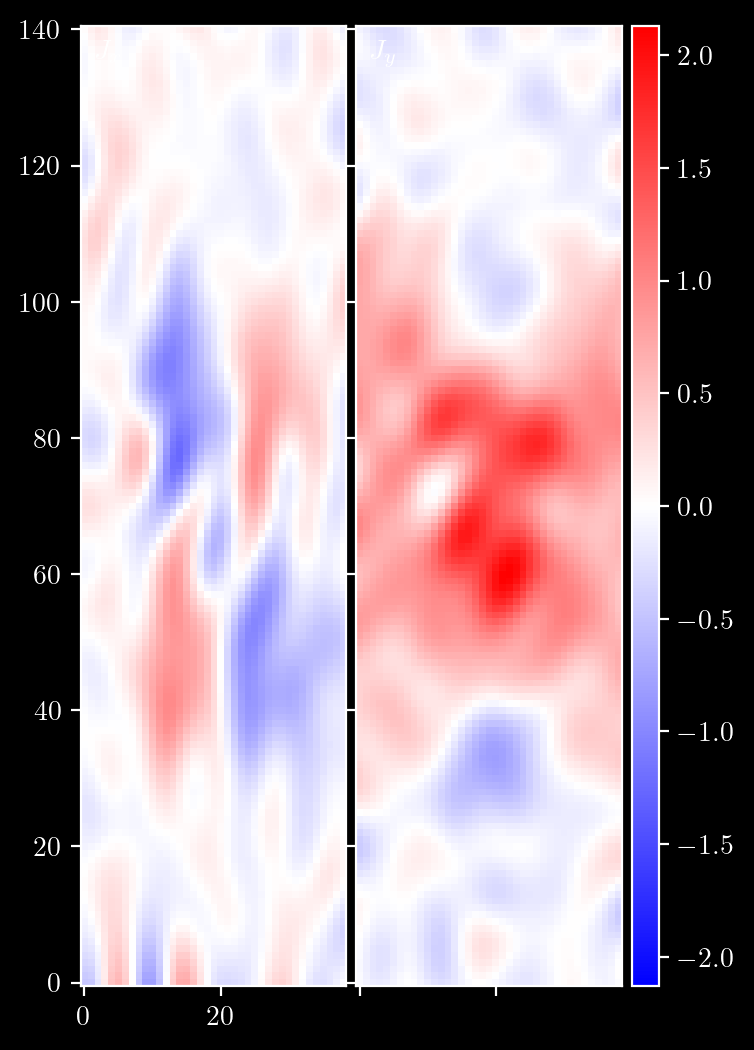

In [111]:
plot_n_components(J, cmap='bwr', labels=['$J_x$', '$J_y$'])

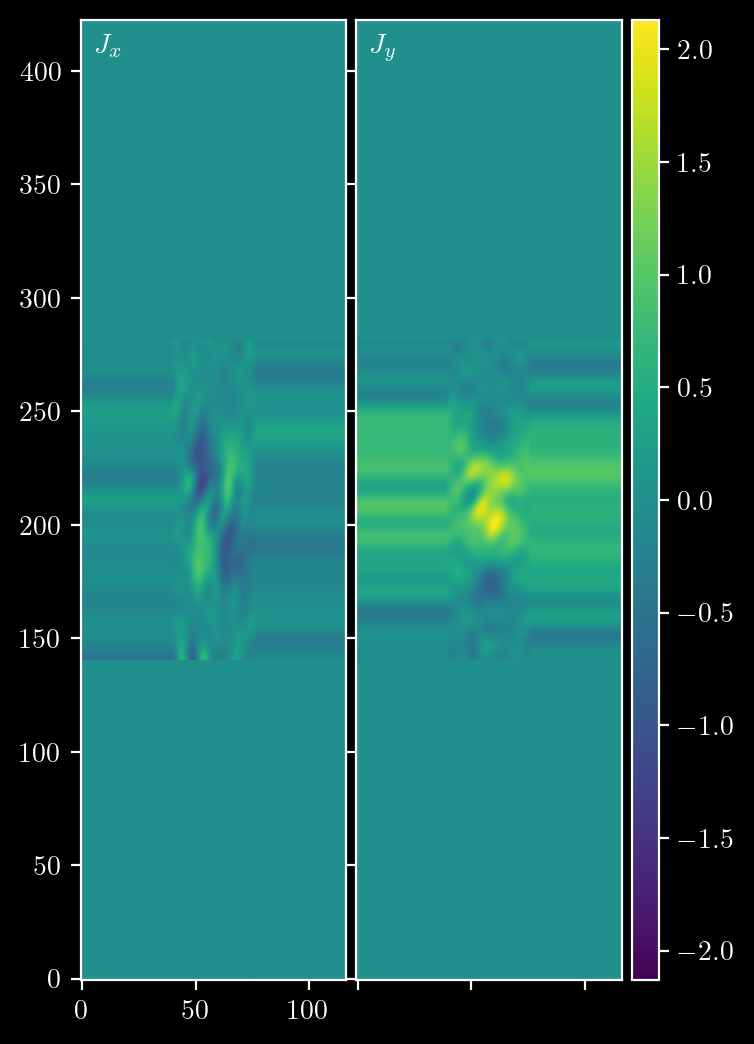

In [118]:
plot_n_components(pad1.pad(J), cmap='viridis', labels=['$J_x$', '$J_y$'])

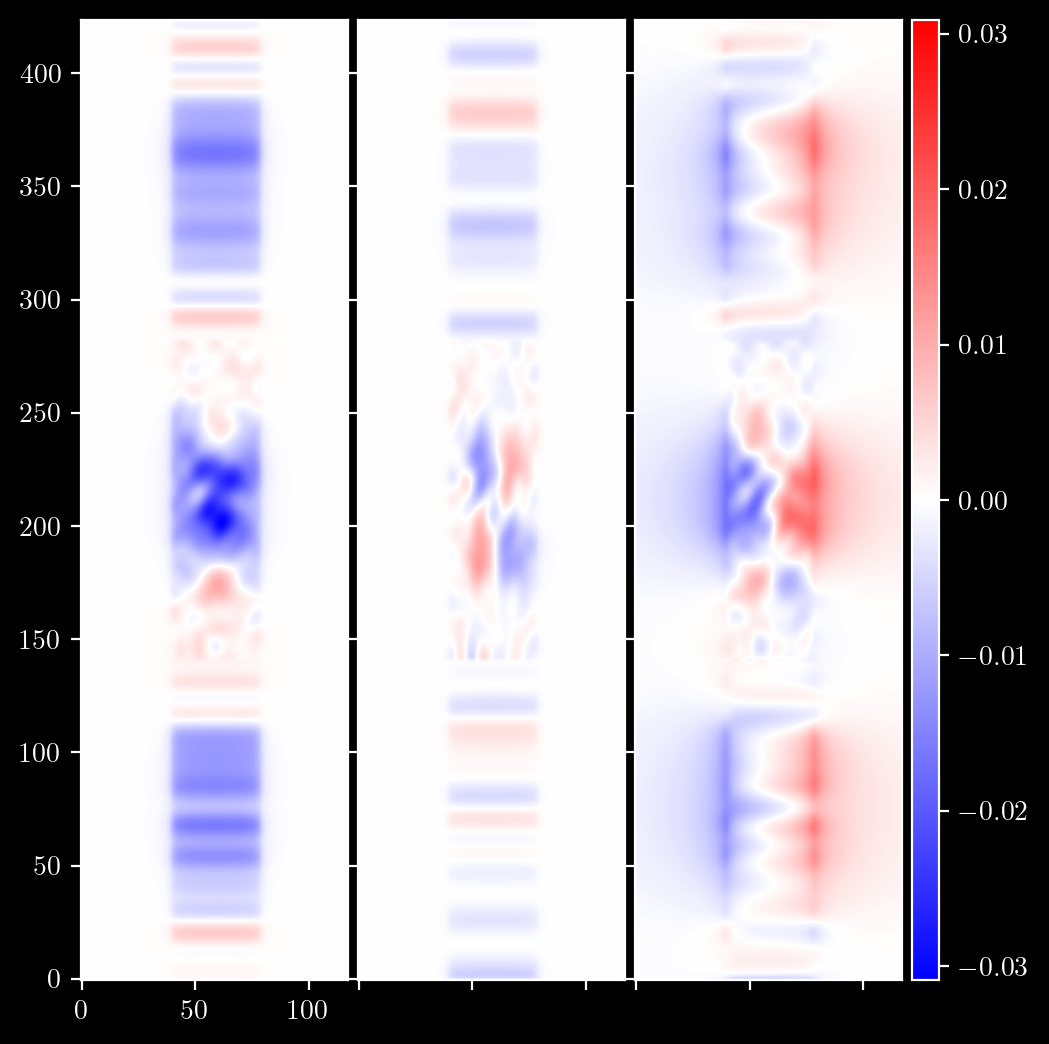

In [110]:
plot_n_components(pad2.unpad(compute_B_NV(J)), cmap='bwr')

In [92]:
J.mean(dim=(-2, -1))

tensor([-0.0218,  0.3232], dtype=torch.float64)